In [10]:
#this was done to extend my regression work from the previous week
#The further things I included are the results for each model for the training data, the std. deviation 
#for both training and test for those results, comments with my observations of the results, and finally
#I extended it to also include SVM as a third option to comapre results with 

import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.ensemble import BaggingRegressor
import math

#+++++++++++++++++++++++++++++++++++++++++++++++++ PREPROCESSING ++++++++++++++++++++++++++++++++++++++++++++++

ice_thickness = pd.read_csv('../data/ice_thickness.csv')
ice_velocity = pd.read_csv('../data/ice_velocity.csv')

#removing any rows with ice_thickness = 0 (looking only at data points with ice for this analysis)
ice_thickness = ice_thickness[ice_thickness['ice_thickness']!=0]

#removing any rows with ice_velocity -1
ice_velocity = ice_velocity[ice_velocity['ice_velocity']!=-1]

#method to normalise the data -> scale each column between 0 and 1 
def scale (df):
    """uses the formula scaled val = (val-column minimum)/(column maximum - column minimum)"""
    scaled_df = df.copy()
    # for column in df.columns[:-1]  -> use this line instead for not having a scaled target 
    for column in scaled_df.columns:
        min_value = scaled_df[column].min()
        max_value = scaled_df[column].max()
        scaled_df[column] = (scaled_df[column] - min_value) / (max_value - min_value)
            
    return scaled_df

def unscale_rmse(scaled_rmse, target_name, original_df):
    target_min = original_df[target_name].min()
    target_max = original_df[target_name].max()

    return scaled_rmse * (target_max - target_min)


def replace_with_abs(df, columns):
    new_df = df.copy()
    for column in columns:
        new_df[column] = new_df[column].abs()
    return new_df



In [11]:
#+++++++++++++++++++++++++++++++++++++++++++++ LINEAR REGRESSION +++++++++++++++++++++++++++++++++++++++++++

def doLinReg(preprocessed_df, seed, n_runs, target_name, original_df):
    train_scores = []
    test_scores = []
    coefficients = []  # Coefficients from training, a list of lists 
    train_RMSEs = []
    test_RMSEs = []

    for i in range(n_runs):
        randomState = i * seed
        X = preprocessed_df.iloc[:, :-1]
        y = preprocessed_df.iloc[:, -1]
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=randomState)

        model = LinearRegression()
        model.fit(X_train, y_train)

        # Store metrics for training set
        train_scores.append(model.score(X_train, y_train))
        coefficients.append(model.coef_)
        y_train_predicted = model.predict(X_train)
        train_scaled_rmse = math.sqrt(mean_squared_error(y_train, y_train_predicted))
        train_rmse = unscale_rmse(train_scaled_rmse, target_name, original_df)
        train_RMSEs.append(train_rmse)

        # Store metrics for test set
        test_scores.append(model.score(X_test, y_test))
        y_test_predicted = model.predict(X_test)
        test_scaled_rmse = math.sqrt(mean_squared_error(y_test, y_test_predicted))
        test_rmse = unscale_rmse(test_scaled_rmse, target_name, original_df)
        test_RMSEs.append(test_rmse)

    # Calculate the average and standard deviation for each metric
    avg_train_score, std_train_score = np.mean(train_scores), np.std(train_scores)
    avg_test_score, std_test_score = np.mean(test_scores), np.std(test_scores)
    avg_coefficients, std_coefficients = np.mean(coefficients, axis=0), np.std(coefficients, axis=0)
    avg_train_rmse, std_train_rmse = np.mean(train_RMSEs), np.std(train_RMSEs)
    avg_test_rmse, std_test_rmse = np.mean(test_RMSEs), np.std(test_RMSEs)

    # Output the results
    print(f"Training Average Score: {avg_train_score:.4f}, Std Dev: {std_train_score:.4f}")
    print(f"Training Average Unscaled RMSE: {avg_train_rmse:.2f}, Std Dev: {std_train_rmse:.2f}")
    print("\n")
    print(f"Test Average Score: {avg_test_score:.4f}, Std Dev: {std_test_score:.4f}")
    print(f"Test Average Unscaled RMSE: {avg_test_rmse:.2f}, Std Dev: {std_test_rmse:.2f}")
    print("\n")
    print("Average Coefficients:", avg_coefficients)
    print("Coefficients Std Dev:", std_coefficients)

    return avg_coefficients, std_coefficients  

In [12]:
#+++++++++++++++++++++++++++++++++++++++++++++ RF REGRESSION +++++++++++++++++++++++++++++++++++++++++++
def doRandomForest(preprocessed_df, seed, n_runs, target_name, original_df):
    train_scores = []
    test_scores = []
    train_RMSEs = []
    test_RMSEs = []
    importances = []

    for i in range(n_runs):
        randomState = i * seed
        X = preprocessed_df.iloc[:, :-1]
        y = preprocessed_df.iloc[:, -1]
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=randomState)

        model = RandomForestRegressor(random_state=randomState)
        model.fit(X_train, y_train)

        # Store metrics for training set
        train_scores.append(model.score(X_train, y_train))
        y_train_predicted = model.predict(X_train)
        train_scaled_rmse = math.sqrt(mean_squared_error(y_train, y_train_predicted))
        train_rmse = unscale_rmse(train_scaled_rmse, target_name, original_df)
        train_RMSEs.append(train_rmse)

        # Store metrics for test set
        test_scores.append(model.score(X_test, y_test))
        importances.append(model.feature_importances_)
        y_test_predicted = model.predict(X_test)
        test_scaled_rmse = math.sqrt(mean_squared_error(y_test, y_test_predicted))
        test_rmse = unscale_rmse(test_scaled_rmse, target_name, original_df)
        test_RMSEs.append(test_rmse)

    # Calculate the average and standard deviation for each metric
    avg_train_score, std_train_score = np.mean(train_scores), np.std(train_scores)
    avg_test_score, std_test_score = np.mean(test_scores), np.std(test_scores)
    avg_train_rmse, std_train_rmse = np.mean(train_RMSEs), np.std(train_RMSEs)
    avg_test_rmse, std_test_rmse = np.mean(test_RMSEs), np.std(test_RMSEs)
    avg_importances, std_importances = np.mean(importances, axis=0), np.std(importances, axis=0)

    # Output the results
    print(f"Training Average Score: {avg_train_score:.4f}, Std Dev: {std_train_score:.4f}")
    print(f"Training Average RMSE: {avg_train_rmse:.2f}, Std Dev: {std_train_rmse:.2f}")
    print("\n")
    print(f"Test Average Score: {avg_test_score:.4f}, Std Dev: {std_test_score:.4f}")
    print(f"Test Average RMSE: {avg_test_rmse:.2f}, Std Dev: {std_test_rmse:.2f}")
    print("\n")
    print("Average Importances:", avg_importances)
    print("Importances Std Dev:", std_importances)


    return avg_importances, std_importances

In [13]:
#+++++++++++++++++++++++++++++++++++++++++++++ SVR LINEAR REGRESSION ++++++++++++++++++++++++++++++++++++++++
def doLinearSVM(preprocessed_df, seed, n_runs, target_name, original_df):
    train_scores = []
    test_scores = []
    train_RMSEs = []
    test_RMSEs = []
    coefficients = []  

    for i in range(n_runs):
        randomState = i * seed
        X = preprocessed_df.iloc[:, :-1]
        y = preprocessed_df.iloc[:, -1]
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=randomState)

        model = SVR(kernel='linear')
        model.fit(X_train, y_train)

        # Store metrics for training set
        train_scores.append(model.score(X_train, y_train))
        coefficients.append(model.coef_[0])
        y_train_predicted = model.predict(X_train)
        train_scaled_rmse = math.sqrt(mean_squared_error(y_train, y_train_predicted))
        train_rmse = unscale_rmse(train_scaled_rmse, target_name, original_df)
        train_RMSEs.append(train_rmse)

        # Store metrics for test set
        test_scores.append(model.score(X_test, y_test))
        y_test_predicted = model.predict(X_test)
        test_scaled_rmse = math.sqrt(mean_squared_error(y_test, y_test_predicted))
        test_rmse = unscale_rmse(test_scaled_rmse, target_name, original_df)
        test_RMSEs.append(test_rmse)

    # Calculate the average and standard deviation for each metric
    avg_train_score, std_train_score = np.mean(train_scores), np.std(train_scores)
    avg_test_score, std_test_score = np.mean(test_scores), np.std(test_scores)
    avg_train_rmse, std_train_rmse = np.mean(train_RMSEs), np.std(train_RMSEs)
    avg_test_rmse, std_test_rmse = np.mean(test_RMSEs), np.std(test_RMSEs)
    avg_coefficients, std_coefficients = np.mean(coefficients, axis=0), np.std(coefficients, axis=0)


    # Output the results
    print(f"Training Average Score: {avg_train_score:.4f}, Std Dev: {std_train_score:.4f}")
    print(f"Training Average Unscaled RMSE: {avg_train_rmse:.2f}, Std Dev: {std_train_rmse:.2f}")
    print("\n")
    print(f"Test Average Score: {avg_test_score:.4f}, Std Dev: {std_test_score:.4f}")
    print(f"Test Average Unscaled RMSE: {avg_test_rmse:.2f}, Std Dev: {std_test_rmse:.2f}")
    print("\n")
    print("Average Coef:", avg_coefficients)
    print("Coef Std Dev:", std_coefficients)

    return avg_coefficients, std_coefficients



In [14]:
#+++++++++++++++++++++++++++++++++++++++++++++ SVR POLY REGRESSION ++++++++++++++++++++++++++++++++++++++++

def doPolySVM(preprocessed_df, seed, n_runs, target_name, original_df):
    train_scores = []
    test_scores = []
    train_RMSEs = []
    test_RMSEs = []

    for i in range(n_runs):
        randomState = i * seed
        X = preprocessed_df.iloc[:, :-1]
        y = preprocessed_df.iloc[:, -1]
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=randomState)

        model = SVR(kernel='poly')
        model.fit(X_train, y_train)

        # Store metrics for training set
        train_scores.append(model.score(X_train, y_train))
        y_train_predicted = model.predict(X_train)
        train_scaled_rmse = math.sqrt(mean_squared_error(y_train, y_train_predicted))
        train_rmse = unscale_rmse(train_scaled_rmse, target_name, original_df)
        train_RMSEs.append(train_rmse)

        # Store metrics for test set
        test_scores.append(model.score(X_test, y_test))
        y_test_predicted = model.predict(X_test)
        test_scaled_rmse = math.sqrt(mean_squared_error(y_test, y_test_predicted))
        test_rmse = unscale_rmse(test_scaled_rmse, target_name, original_df)
        test_RMSEs.append(test_rmse)

    # Calculate the average and standard deviation for each metric
    avg_train_score, std_train_score = np.mean(train_scores), np.std(train_scores)
    avg_test_score, std_test_score = np.mean(test_scores), np.std(test_scores)
    avg_train_rmse, std_train_rmse = np.mean(train_RMSEs), np.std(train_RMSEs)
    avg_test_rmse, std_test_rmse = np.mean(test_RMSEs), np.std(test_RMSEs)

    # Output the results
    print(f"Training Average Score: {avg_train_score:.4f}, Std Dev: {std_train_score:.4f}")
    print(f"Training Average Unscaled RMSE: {avg_train_rmse:.2f}, Std Dev: {std_train_rmse:.2f}")
    print("\n")
    print(f"Test Average Score: {avg_test_score:.4f}, Std Dev: {std_test_score:.4f}")
    print(f"Test Average Unscaled RMSE: {avg_test_rmse:.2f}, Std Dev: {std_test_rmse:.2f}")

In [15]:
#++++++++++++++++++++++++++++++++++++++++++++++++ ICE THICKNESS ++++++++++++++++++++++++++++++++++++++++++++
print("REG XY LINREG")
seed = 101
scaled_df = scale(ice_thickness)
coef_IT, std_coef_IT = doLinReg(scaled_df, seed, 30, "ice_thickness", ice_thickness)

print('\n\nREG XY RANDOM FOREST')
importances_IT, std_importances_IT = doRandomForest(scaled_df, seed, 30, "ice_thickness", ice_thickness)

print('\n+++REG XY LINEAR SVM+++')
svm_coef_IT, svm_std_coef_IT = doLinearSVM(scaled_df, seed, 30, "ice_thickness", ice_thickness)

print('\n+++REG XY POLY SVM+++')
doPolySVM(scaled_df, seed, 30, "ice_thickness", ice_thickness)

print("\nABS XY LINREG")
abs_df = replace_with_abs(ice_thickness, ['x-axis', 'y-axis'])
abs_scaled_df = scale(abs_df)
abs_coef_IT, abs_std_coef_IT = doLinReg(abs_scaled_df, seed, 30, "ice_thickness", ice_thickness)

print("\nABS XY RANDOM FOREST")
abs_df = replace_with_abs(ice_thickness, ['x-axis', 'y-axis'])
abs_scaled_df = scale(abs_df)
abs_importances_IT, abs_std_importances_IT = doRandomForest(abs_scaled_df, seed, 30, "ice_thickness", ice_thickness)

print('\n+++ABS XY LINEAR SVM+++')
abs_df = replace_with_abs(ice_thickness, ['x-axis', 'y-axis'])
abs_scaled_df = scale(abs_df)
abs_svm_coef_IT, abs_svm_std_coef_IT = doLinearSVM(abs_scaled_df, seed, 30, "ice_thickness", ice_thickness)

print('\n+++ABS XY POLY SVM+++')
abs_df = replace_with_abs(ice_thickness, ['x-axis', 'y-axis'])
abs_scaled_df = scale(abs_df)
doPolySVM(abs_scaled_df, seed, 30, "ice_thickness", ice_thickness)


REG XY LINREG
Training Average Score: 0.6711, Std Dev: 0.0093
Training Average Unscaled RMSE: 615.89, Std Dev: 9.13


Test Average Score: 0.6716, Std Dev: 0.0215
Test Average Unscaled RMSE: 617.34, Std Dev: 21.24


Average Coefficients: [-0.03393994 -0.17595196  0.12930657 -0.88062739  0.33196438]
Coefficients Std Dev: [0.01548531 0.013011   0.02525444 0.009246   0.03004117]


REG XY RANDOM FOREST
Training Average Score: 0.9781, Std Dev: 0.0010
Training Average RMSE: 159.09, Std Dev: 3.53


Test Average Score: 0.8459, Std Dev: 0.0158
Test Average RMSE: 422.53, Std Dev: 20.21


Average Importances: [0.09587474 0.07568742 0.04938001 0.69946764 0.07959019]
Importances Std Dev: [0.00861895 0.00439179 0.00442732 0.01031886 0.00932389]

+++REG XY LINEAR SVM+++
Training Average Score: 0.6687, Std Dev: 0.0094
Training Average Unscaled RMSE: 618.11, Std Dev: 9.24


Test Average Score: 0.6687, Std Dev: 0.0223
Test Average Unscaled RMSE: 620.00, Std Dev: 21.95


Average Coef: [-0.01406105 -0.1793

In [37]:
#++++++++++++++++++++++++++++++++++++++++++++++++ ICE VELOCITY ++++++++++++++++++++++++++++++++++++++++++++
print("REG XY LINREG")
seed = 101
scaled_df = scale(ice_velocity)
coef_IV, std_coef_IV = doLinReg(scaled_df, seed, 30, "ice_velocity", ice_velocity)

print('\n\nREG XY RANDOM FOREST')
importances_IV, std_importances_IV = doRandomForest(scaled_df, seed, 30, "ice_velocity", ice_velocity)

print('\n+++REG XY LINEAR SVM+++')
svm_coef_IV, svm_std_coef_IV = doLinearSVM(scaled_df, seed, 30, "ice_velocity", ice_velocity)

print('\n+++REG XY POLY SVM+++')
doPolySVM(scaled_df, seed, 30, "ice_velocity", ice_velocity)

print("\nABS XY LINREG")
abs_df = replace_with_abs(ice_velocity, ['x-axis', 'y-axis'])
abs_scaled_df = scale(abs_df)
abs_coef_IV, abs_std_coef_IV = doLinReg(abs_scaled_df, seed, 30, "ice_velocity", ice_velocity)

print("\nABS XY RANDOM FOREST")
abs_importances_IV, abs_std_importances_IV = doRandomForest(abs_scaled_df, seed, 30, "ice_velocity", ice_velocity)

print('\n+++ABS XY LINEAR SVM+++')
abs_svm_coef_IV, abs_svm_std_coef_IV = doLinearSVM(abs_scaled_df, seed, 30, "ice_velocity", ice_velocity)

print('\n+++ABS XY POLY SVM+++')
doPolySVM(abs_scaled_df, seed, 30, "ice_velocity", ice_velocity)


REG XY LINREG
Training Average Score: 0.1701, Std Dev: 0.0249
Training Average Unscaled RMSE: 277.41, Std Dev: 21.73


Test Average Score: 0.1131, Std Dev: 0.0735
Test Average Unscaled RMSE: 282.74, Std Dev: 49.17


Average Coefficients: [ 0.05070234  0.01485978  0.22482359  0.06979412 -0.05801929]
Coefficients Std Dev: [0.02198219 0.01139877 0.06472    0.01432592 0.02910283]


REG XY RANDOM FOREST
Training Average Score: 0.8707, Std Dev: 0.0136
Training Average RMSE: 109.24, Std Dev: 8.75


Test Average Score: 0.0014, Std Dev: 0.2240
Test Average RMSE: 295.44, Std Dev: 42.79


Average Importances: [0.08589561 0.12249242 0.22177165 0.37890984 0.19093048]
Importances Std Dev: [0.01213408 0.02661108 0.04496875 0.05545489 0.02851606]

+++REG XY LINEAR SVM+++
Training Average Score: -0.7458, Std Dev: 0.2235
Training Average Unscaled RMSE: 399.88, Std Dev: 13.80


Test Average Score: -0.8405, Std Dev: 0.4562
Test Average Unscaled RMSE: 398.45, Std Dev: 36.79


Average Coef: [ 0.00411083  0.

In [17]:
#++++++++++++++++++++++++++++++++++++++++++++++++++RESULTS DATAFRAMES++++++++++++++++++++++++++++++++++++++++++
cols = ['x-axis', 'y-axis', "precipitation", "air_temp", "ocean_temp"]

#++++++++++++++++++++++++++++++++++++++++++++++ICE THICKNESS++++++++++++++++++++++++++++++++++++++++++++++++++
coef_IT_df = pd.DataFrame([coef_IT], columns=cols)
abs_coef_IT_df = pd.DataFrame([abs_coef_IT], columns=cols)

importances_IT_df = pd.DataFrame([importances_IT], columns=cols)
abs_importances_IT_df = pd.DataFrame([abs_importances_IT], columns=cols)


svm_coef_IT_df = pd.DataFrame([svm_coef_IT], columns=cols)
abs_svm_coef_IT_df = pd.DataFrame([abs_svm_coef_IT], columns=cols)

#++++++++++++++++++++++++++++++++++++++++++++++++ICE VELOCITY++++++++++++++++++++++++++++++++++++++++++++++++++

coef_IV_df = pd.DataFrame([coef_IV], columns=cols)
abs_coef_IV_df = pd.DataFrame([abs_coef_IV], columns=cols)

importances_IV_df = pd.DataFrame([importances_IV], columns=cols)
abs_importances_IV_df = pd.DataFrame([abs_importances_IV], columns=cols)


svm_coef_IV_df = pd.DataFrame([svm_coef_IV], columns=cols)
abs_svm_coef_IV_df = pd.DataFrame([abs_svm_coef_IV], columns=cols)


In [27]:
def plot_coefficients(coef_df, std_dev, title):
    for column in coef_df.columns: 
        coef_df[column] = coef_df[column].abs()
            
    transposed_linreg_coef = coef_df.T
    transposed_linreg_coef.reset_index(inplace=True)
    transposed_linreg_coef.columns = ['Feature', 'Coefficient']

    plt.figure(figsize=(10, 6))
    plt.bar(transposed_linreg_coef['Feature'], transposed_linreg_coef['Coefficient'], color='skyblue')

    # Add error bars
    plt.errorbar(transposed_linreg_coef['Feature'], transposed_linreg_coef['Coefficient'], yerr=std_dev, fmt='o', color='black', capsize=5)

    plt.xlabel('Features')
    plt.ylabel('Coefficient Value')
    plt.title(title, fontweight = 'bold', fontsize = 15)
    plt.xticks(rotation=45)
    plt.show()



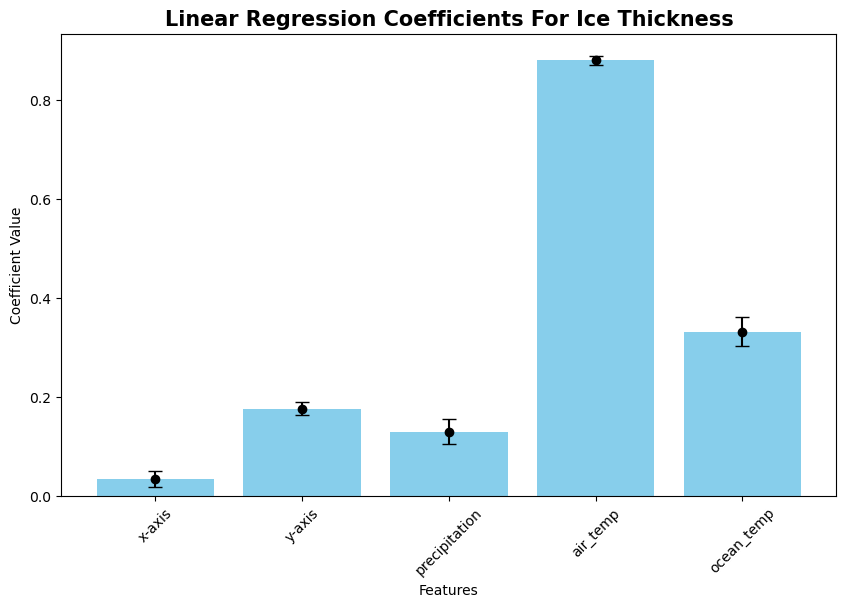

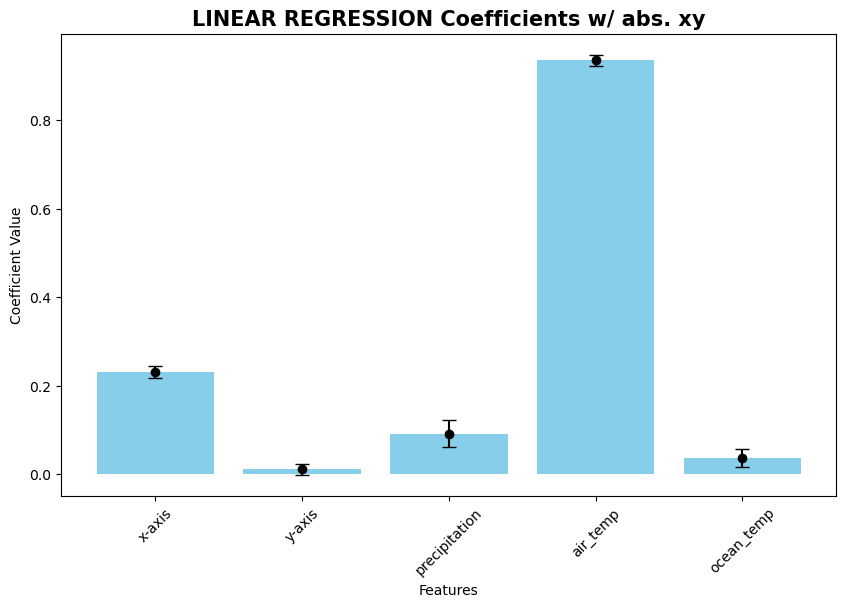

In [28]:
#+++++++++++++++++++++++++++++++LINEAR REGRESSION CHARTS FOR THICKNESS++++++++++++++++++++++++++++++++++++
plot_coefficients(coef_IT_df, std_coef_IT, "Linear Regression Coefficients For Ice Thickness")
plot_coefficients(abs_coef_IT_df, abs_std_coef_IT, "LINEAR REGRESSION Coefficients w/ abs. xy")


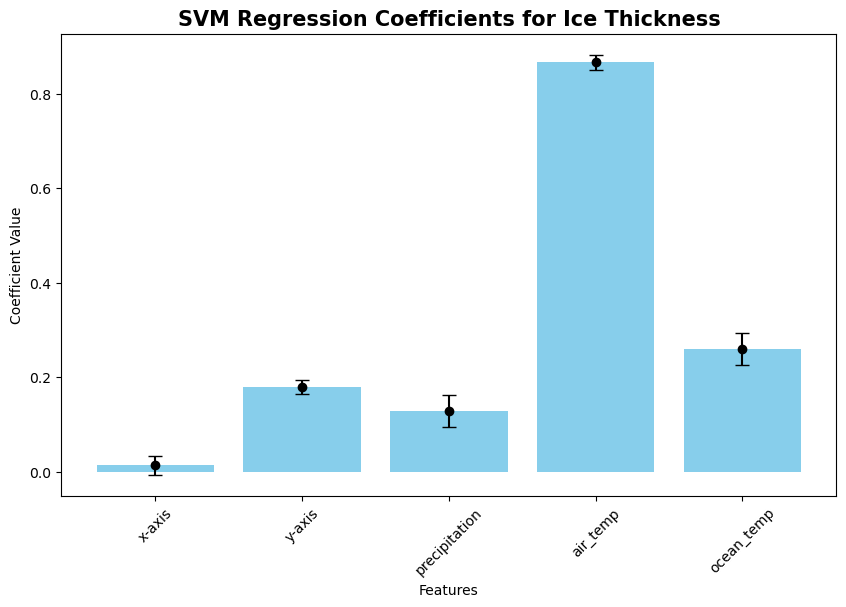

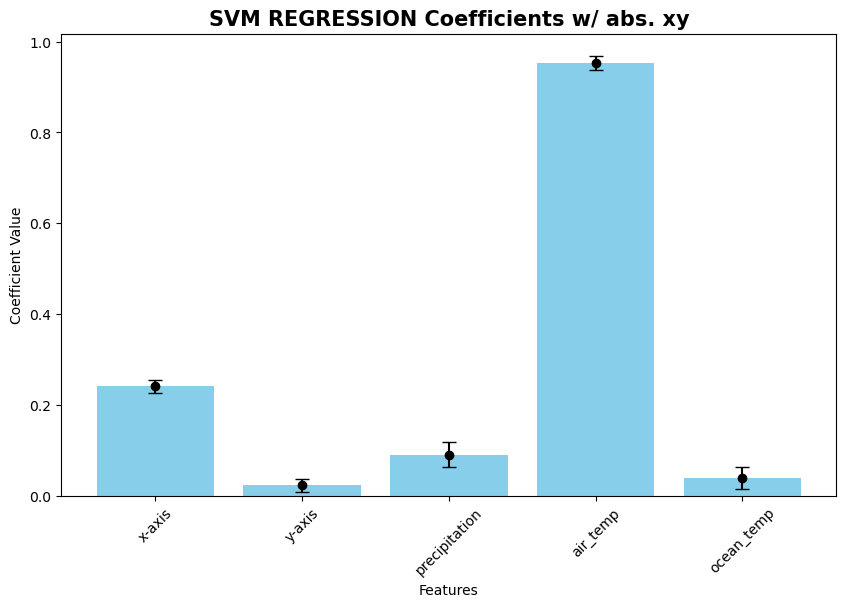

In [29]:
#+++++++++++++++++++++++++++++++SVM REGRESSION CHARTS FOR THICKNESS++++++++++++++++++++++++++++++++++++
plot_coefficients(svm_coef_IT_df, svm_std_coef_IT, "SVM Regression Coefficients for Ice Thickness")
plot_coefficients(abs_svm_coef_IT_df, abs_svm_std_coef_IT, "SVM REGRESSION Coefficients w/ abs. xy")


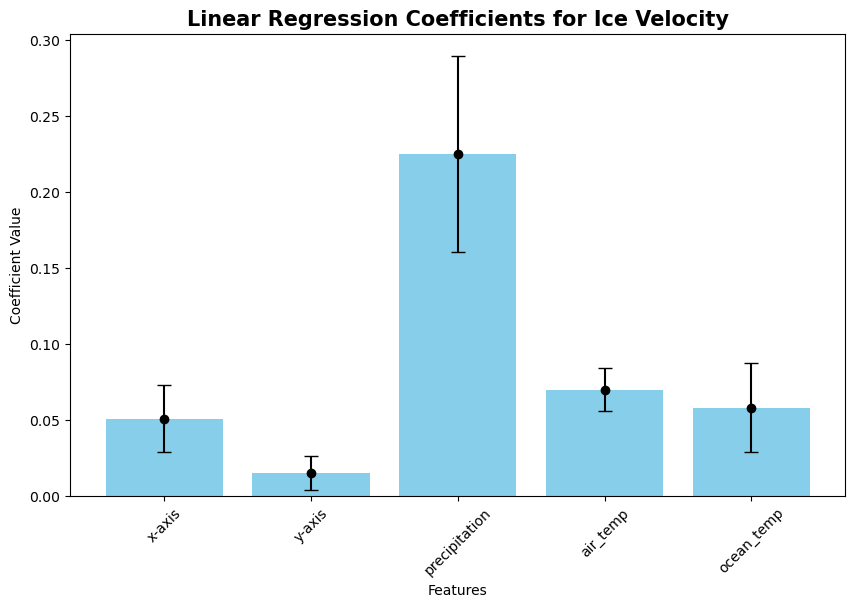

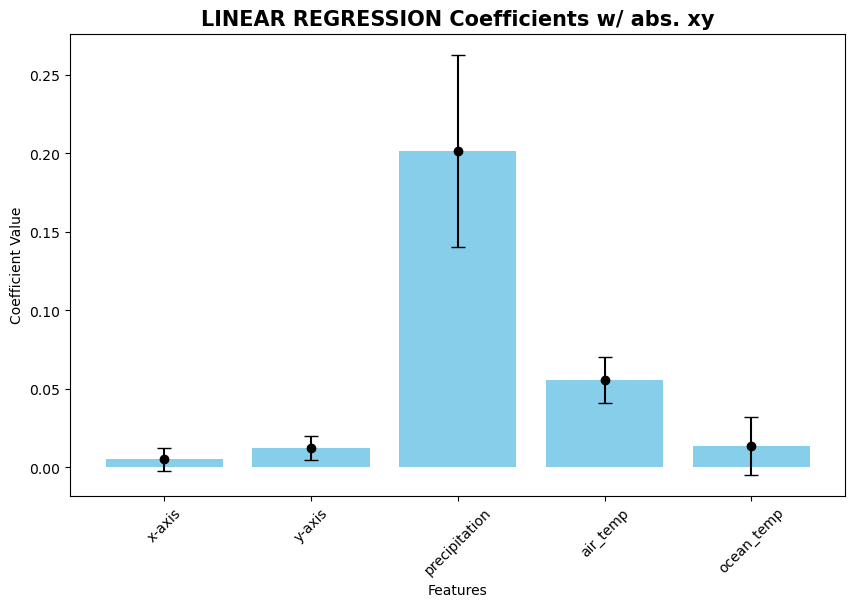

In [30]:
#+++++++++++++++++++++++++++++++LINEAR REGRESSION CHARTS FOR VELOCITY++++++++++++++++++++++++++++++++++++
plot_coefficients(coef_IV_df, std_coef_IV, "Linear Regression Coefficients for Ice Velocity")
plot_coefficients(abs_coef_IV_df, abs_std_coef_IV, "LINEAR REGRESSION Coefficients w/ abs. xy")


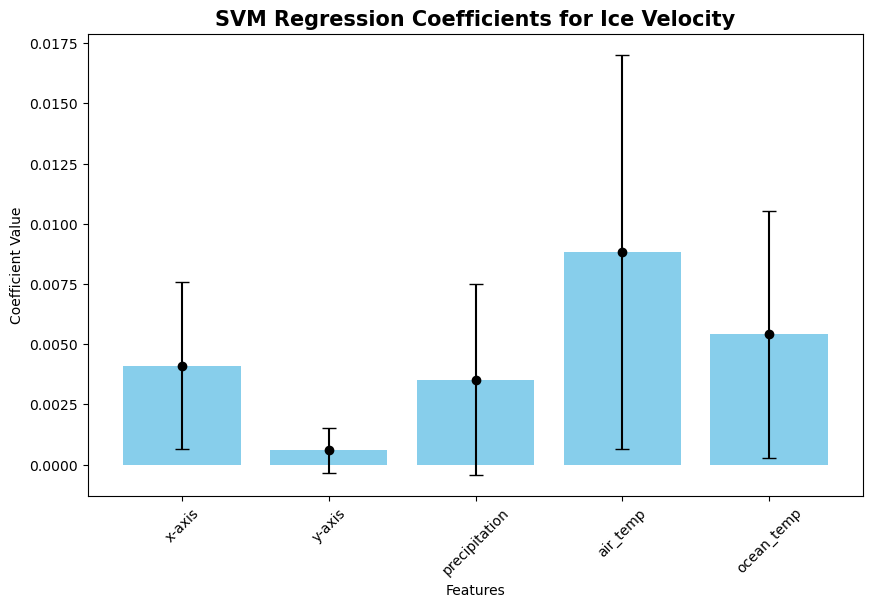

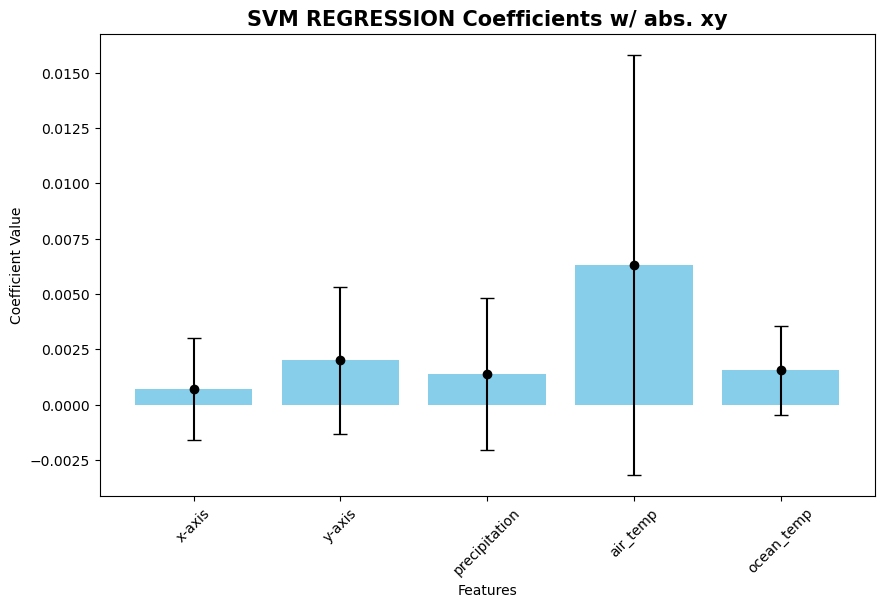

In [31]:
#+++++++++++++++++++++++++++++++SVM REGRESSION CHARTS FOR VELOCITY++++++++++++++++++++++++++++++++++++
plot_coefficients(svm_coef_IV_df, svm_std_coef_IV, "SVM Regression Coefficients for Ice Velocity")
plot_coefficients(abs_svm_coef_IV_df, abs_svm_std_coef_IV, "SVM REGRESSION Coefficients w/ abs. xy")


In [34]:
def plot_importance(importance_df, std_dev, title):
    for column in importance_df.columns: 
            importance_df[column] = importance_df[column].abs()
            
    transposed_importance_df = importance_df.T
    transposed_importance_df.reset_index(inplace=True)
    transposed_importance_df.columns = ['Feature', 'Importance']
    
    plt.figure(figsize=(10, 6))
    plt.bar(transposed_importance_df['Feature'], transposed_importance_df['Importance'], color='skyblue')
    
    #Error bars 
    plt.errorbar(transposed_importance_df['Feature'], transposed_importance_df['Importance'], yerr=std_dev, fmt='o', color='black', capsize=5)
        
    plt.xlabel('Features')
    plt.ylabel('Importance Value')
    plt.title(title, fontsize = 15, fontweight = 'bold')
    plt.xticks(rotation=45)
    plt.show()
    

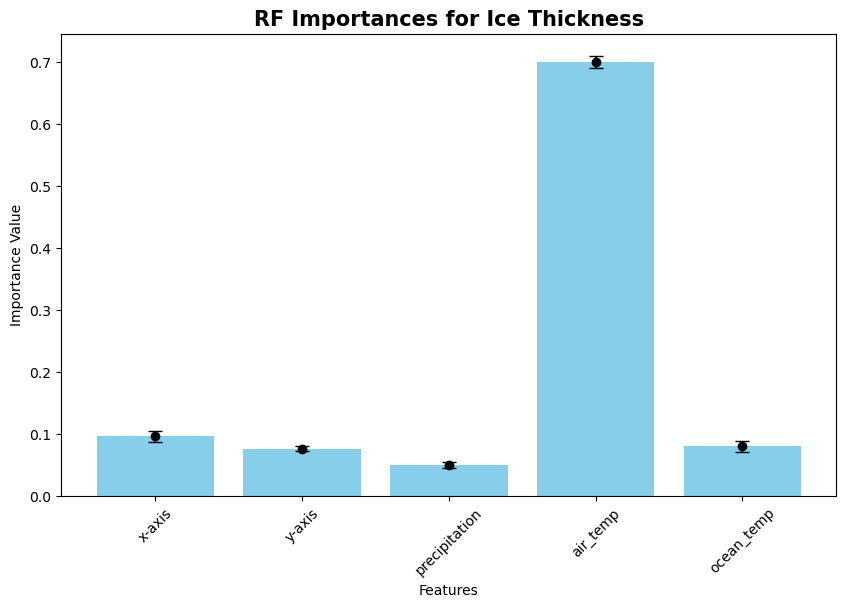

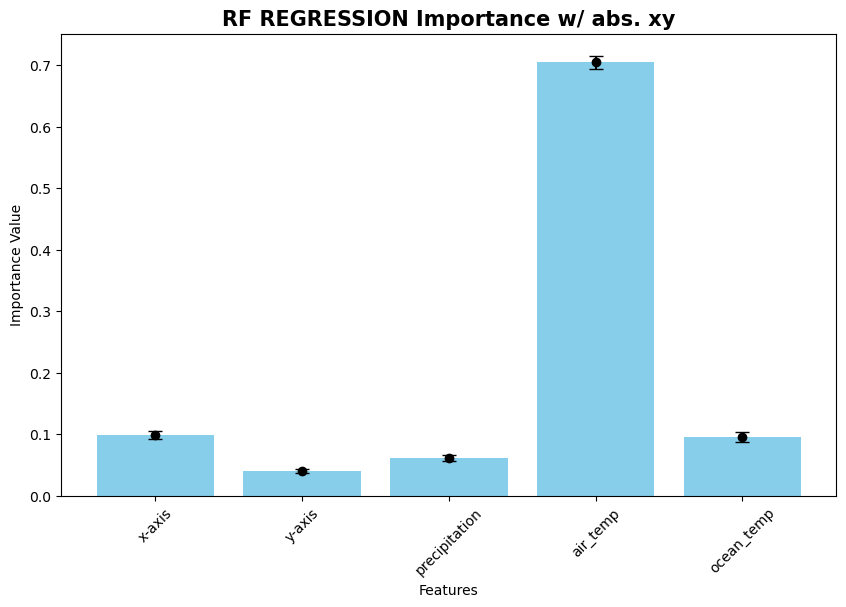

In [35]:
#+++++++++++++++++++++++++++++++RF REGRESSION CHARTS FOR THICKNESS++++++++++++++++++++++++++++++++++++
plot_importance(importances_IT_df, std_importances_IT, "RF Importances for Ice Thickness")


plot_importance(abs_importances_IT_df, abs_std_importances_IT, "RF REGRESSION Importance w/ abs. xy")


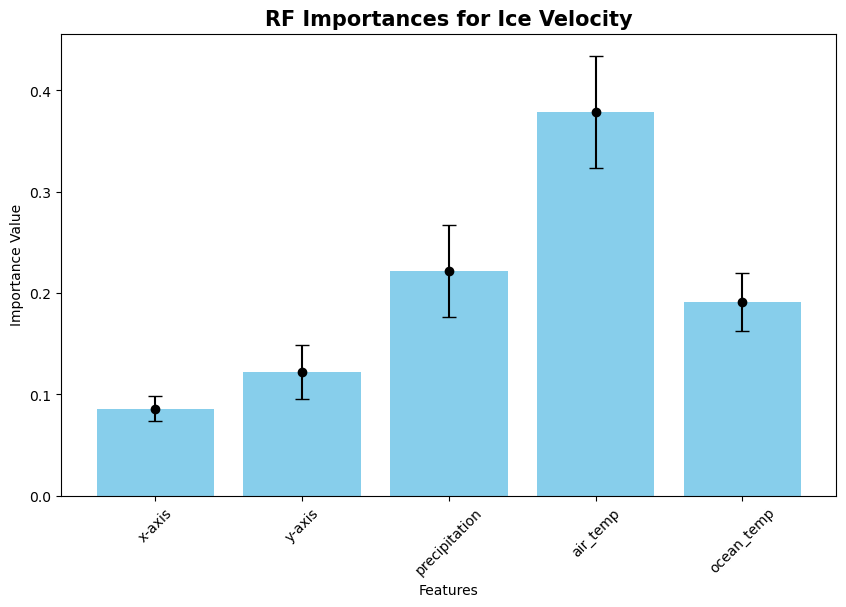

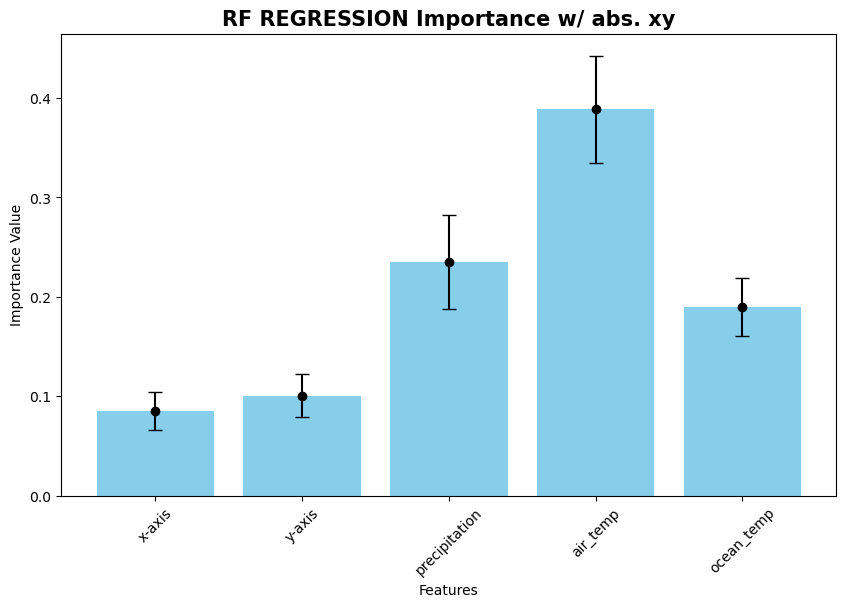

In [36]:
#+++++++++++++++++++++++++++++++RF REGRESSION CHARTS FOR VELOCITY++++++++++++++++++++++++++++++++++++
plot_importance(importances_IV_df, std_importances_IV, "RF Importances for Ice Velocity")
plot_importance(abs_importances_IV_df, abs_std_importances_IV, "RF REGRESSION Importance w/ abs. xy")
